## Postcode price lookup

Welcome to my work on estimating house prices. 

To run the class you will need two additional files:

this is to convert between postcodes and local area codes
https://opendata.camden.gov.uk/Maps/Postcodes-Local-Authorities-only-v01/g3bz-7ur8

this is to relate local area codes to their house price inflation
https://www.gov.uk/government/statistical-data-sets/uk-house-price-index-data-downloads-january-2022

All files need to be in the same directory, which you can pass to the class using data_location

the class works on these principles:

if we have a direct match for a postcode, we should estimate the price using that
if we do not, then we use the first 3 letters of the postcode (perhaps would be better to use a smaller area e.g postcode -1, postcode -2)

If we can find that postcode in our house price index lookup, then we will also generate an inflation-adjusted estimate

The second class inherits from this, and adds a function that can be used to adjust what is returned (i.e. if we want to apply some cut on the standard error, we want to limit the fields returned etc.)

In [13]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


class HousePriceEstimator(object):
    
    def __init__(self, data_location):
        self.__NECESSARY_FILES__ = ['pp-2018.csv', 
                                    'pp-2019.csv', 
                                    'pp-2020.csv', 
                                    'Postcode districts.csv', 
                                    'UK-HPI-full-file-2022-01.csv',
                                   'Postcodes___Local_Authorities_only_v01.csv']
        self._data_location = data_location
        self._house_prices, self._pc_dist, self._hpi_file, self.postcode_lookup = self._load_data()
        self._enrich_data()
    
    def _load_data(self):
        """Load the data files needed for the lookup"""
        
        if len(set(self.__NECESSARY_FILES__) - set(os.listdir(self._data_location)))> 0:
            raise ValueError('All Necessary files are not in data_location.')
            
        else:
            _pp_2018 = pd.read_csv(os.path.join(self._data_location, 'pp-2018.csv'), header=None, usecols = [1,2,3])
            _pp_2019 = pd.read_csv(os.path.join(self._data_location, 'pp-2019.csv'), header=None, usecols = [1,2,3])
            _pp_2020 = pd.read_csv(os.path.join(self._data_location, 'pp-2020.csv'), header=None, usecols = [1,2,3])
            
            house_prices= _pp_2018.append(_pp_2019).append(_pp_2020)
            
            del _pp_2018, _pp_2019, _pp_2020
        
            _pc_dist = pd.read_csv(os.path.join(self._data_location, 'Postcode districts.csv'))
            
            # make the postcode to local authority code lookup
            postcode_lookup = pd.read_csv(os.path.join(self._data_location, 'Postcodes___Local_Authorities_only_v01.csv'), usecols = ['Postcode 2', 'Local Authority Code'])
            postcode_lookup['postcode_part1'] = postcode_lookup['Postcode 2'].str.split(' ').apply(lambda x: x[0])
            postcode_lookup['Postcode 2'] = postcode_lookup['Postcode 2'].str.replace('  ', ' ')

            # avg house prices per month file
            hpi_file = pd.read_csv(os.path.join(self._data_location, 'UK-HPI-full-file-2022-01.csv'), usecols = ['Date', 'AreaCode', 'AveragePrice'])
            hpi_file['Date'] = pd.to_datetime(hpi_file['Date'], format = '%d/%m/%Y').astype('datetime64[M]')
            hpi_file = hpi_file.loc[(hpi_file['Date']>= '2018-01-01'),:].copy()

            
            return house_prices, _pc_dist, hpi_file, postcode_lookup
    
    def _enrich_data(self):
        """merge the two file types, tidy some columns"""
        self._house_prices.columns = ['sale_price', 'sale_date', 'postcode']
        self._house_prices['sale_date'] = pd.to_datetime(self._house_prices['sale_date'])
            
        self._house_prices['postcode_district'] = self._house_prices['postcode'].str.split(' ').apply(lambda x: x[0] if type(x) == list else x)
            
        self._house_prices = self._house_prices.merge(self._pc_dist[['Postcode',
                                                'Postcodes',
                                                'Active postcodes',
                                                'Population',
                                                'Households',
                                                'Nearby districts']], left_on='postcode_district', right_on= 'Postcode', how='left')
        
        self._house_prices['sale_date_month'] = self._house_prices['sale_date'].astype('datetime64[M]')
    
    
    def estimate_price(self, postcode, date = None, plotting=True):
        """function for the user to use to estimate a price"""
        if type(postcode) is not str:
            raise ValueError('provide string postcode')
        if not ' ' in postcode:
            raise ValueError('provide postcode with space formatting')
        if len(postcode)< 6 or len(postcode) > 8:
            raise ValueError('postcode is either too short or too long')
        if not date:
            date = datetime.today().strftime('%Y-%m-%d')
        
        # do we have exact match on that postcode?
        sales = self._house_prices.loc[self._house_prices['postcode']== postcode, :].copy()
        if sales.shape[0]>0:
            aggregated_data = self._estimate_for_known_postcode(sales, postcode, plotting)
        else:
            aggregated_data = self.estimate_for_unknown_postcode(postcode, date, plotting)
        return aggregated_data
        
        
    def _estimate_for_known_postcode(self, sales, postcode, plotting):
        """function to estimate when we have exact match on postcode"""
        sales.sort_values(by= 'sale_date', inplace=True)
        aggregated_data = self._aggregate_postcode_data(sales, postcode, plotting)
        return aggregated_data
    
    
    def _aggregate_postcode_data(self,sales, postcode, plotting):
        """aggregate the data into a dict and send it back"""
        
        sales = self._apply_inflation(sales, postcode, date=None)
        if plotting:
            plt.figure(figsize=(15,10));
            nbins = max(int(sales.shape[0]/10), 5)
            sales['sale_price'].hist(bins= nbins);
            plt.title('histogram of sale prices');
            plt.show();
            
            plt.figure(figsize=(15,10));
            plt.scatter(sales['sale_date'], sales['sale_price']);
            plt.title('sale price vs sale date for postcode {}'.format(sales['postcode'].iloc[0]));
            plt.show()
        
        if 'inflated_price' in sales.columns.to_list():
            inflated_mean = sales['inflated_price'].mean()
            inflated_std = sales['inflated_price'].std()
            inflated_std_err_sale_price = sales['inflated_price'].std()/sales.shape[0]**0.5
            inflated_std_err_frac = (sales['inflated_price'].std()/sales.shape[0]**0.5)/ sales['inflated_price'].mean()
        else:
            inflated_mean = np.nan
            inflated_std = np.nan
            inflated_std_err_sale_price = np.nan
            inflated_std_err_frac = np.nan
            
        aggregated_data = {'most_recent_sale_price': sales.iloc[-1]['sale_price'],
                           'most_recent_sale_price_date': sales.iloc[-1]['sale_date'],
                           'mean_sale_price': sales['sale_price'].mean(), 
                           'std_sale_price': sales['sale_price'].std(),
                           'std_err_sale_price': sales['sale_price'].std()/sales.shape[0]**0.5,
                           'std_err_frac': (sales['sale_price'].std()/sales.shape[0]**0.5)/ sales['sale_price'].mean(),
                           'inflated_std_err_sale_price': inflated_std_err_sale_price,
                           'inflated_std_err_frac': inflated_std_err_frac,
                           'n_sales': sales.shape[0], 
                           'mean_sale_price_inflation_adjusted': inflated_mean,
                           'std_sale_price_infaltion_adjusted': inflated_std,
                           'min_sale_price': sales['sale_price'].min(),
                           'min_sale_price_date': sales.sort_values(by= 'sale_price').iloc[0]['sale_date'],
                           'max_sale_price': sales['sale_price'].max(),
                           'max_sale_price_date': sales.sort_values(by= 'sale_price', ascending=False).iloc[0]['sale_date'],
                           #'mean_sale_price_2018': sales.loc[sales.sale_date<'2019-01-01','sale_price'].mean(),
                           #'std_sale_price_2018': sales.loc[sales.sale_date<'2019-01-01','sale_price'].std(),
                           #'mean_sale_price_2019': sales.loc[(sales.sale_date>='2019-01-01') & 
                           #                                  (sales.sale_date<='2020-01-01') ,'sale_price'].mean(),
                           ##'std_sale_price_2019': sales.loc[(sales.sale_date>='2019-01-01') & 
                           #                                  (sales.sale_date<='2020-01-01') ,'sale_price'].std(),
                           #'mean_sale_price_2020': sales.loc[(sales.sale_date>='2020-01-01') & 
                           #                                  (sales.sale_date<='2021-01-01') ,'sale_price'].mean(),
                           #'std_sale_price_2020': sales.loc[(sales.sale_date>='2020-01-01') & 
                           #                                  (sales.sale_date<='2021-01-01') ,'sale_price'].std(),
                          }
        
        return aggregated_data
    
    def estimate_for_unknown_postcode(self, postcode, date, plotting):
        """ function to estimate when we have no exact matches"""
        postcode_district = postcode.split(' ')[0]
        
        sales = self._house_prices.loc[self._house_prices['postcode_district']==postcode_district,:].copy()
        
        if sales.empty:
            #just return no data here?
            #do we also want to check for nearby postcode areas too?
            # eg. close_postcodes = self._pc_dist.loc[self._pc_dist['Postcode']==postcode_district,'Nearby districts']
            raise ValueError('Could not find any sales in that postcode district')
        else:
            sales.sort_values(by= 'sale_date', inplace=True)
            aggregated_data = self._aggregate_postcode_data(sales, postcode, plotting)
        return aggregated_data
        
    
    def _apply_inflation(self, sales,postcode, date = None):
        """This function checks what the avg sale prices are like in the date we are 
        searching for (by default this will be the latest date we have info for)
        
        it uses that to estimate how much an historic 
        sale would have been if it had taken place in current date.
        
        """        
        area = self.postcode_lookup.loc[self.postcode_lookup['Postcode 2'] == postcode, 'Local Authority Code']
        if area.empty:
            print('warning: cannot match postcode to a local area')
            return sales
        else:
            area = area.iloc[0]
        prices = self._hpi_file.loc[self._hpi_file['AreaCode'] == area,:].copy()
        if prices.empty:
            print('WARNING: NO HISTORIC DATA FOUND FOR POSTCODE IN INFLATION FILE')
            return sales
        else:
            #calculate %age change in prices
            if date == None:
                date = prices['Date'].max()
            elif date > prices['Date'].max():
                date = prices['Date'].max()
            elif date < prices['Date'].min():
                date = prices['Date'].min()
            else:
                pass
            prices['current_avg'] = prices.loc[prices['Date']==date, 'AveragePrice'].values[0]
            prices['inflation'] = (prices['current_avg'] - prices['AveragePrice'] )/ prices['AveragePrice']
            sales = sales.merge(prices[['Date', 'inflation']], left_on = 'sale_date_month', right_on = 'Date', how = 'left')
            sales['inflated_price'] = sales['sale_price'] + (sales['sale_price'] * sales['inflation'])
            return sales
        
        
        

In [14]:
class HousePriceReccomendation(HousePriceEstimator):
    
    def __init__(self, data_locaton, reccomendation_settings = {}):
        super().__init__(data_locaton)
        if 'uncertainty_cutoff' not in reccomendation_settings.keys():
            reccomendation_settings['uncertainty_cutoff'] = 0.1 # if our standard error is 10% of our mean sale price or more then do not return
        if 'return_fields' not in reccomendation_settings.keys():
            reccomendation_settings['return_fields'] = ['most_recent_sale_price', 'most_recent_sale_price_date',
                                                                                  'mean_sale_price',
                                                                                  'std_sale_price',
                                                        'mean_sale_price_inflation_adjusted',
                                                        'std_sale_price_infaltion_adjusted',
                                                                                  'std_err_frac',
                                                                                  'n_sales', 
                                                                                  'min_sale_price', 
                                                                                  'max_sale_price']
        self._reccomendation_settings = reccomendation_settings
        
    def get_recommendation(self,postcode,date= None, plotting=True):
        results = self.estimate_price(postcode, date, plotting)
        if 'uncertainty_cutoff' in self._reccomendation_settings.keys():
            results_std_err = results['std_sale_price']/ results['n_sales']**0.5
            results_std_err_pct = results_std_err/ results['mean_sale_price']
            if results_std_err_pct > self._reccomendation_settings['uncertainty_cutoff']:
                return {'Error': 'Uncertainty in price estimate too high to be quoted'
                       }
            else:
                return {k:v for k,v in results.items() if k in self._reccomendation_settings['return_fields']}

## example of house price estimator

In [6]:
hpe = HousePriceEstimator('../data')

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_32046/2820493123.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  house_prices= _pp_2018.append(_pp_2019).append(_pp_2020)


### matched postcode

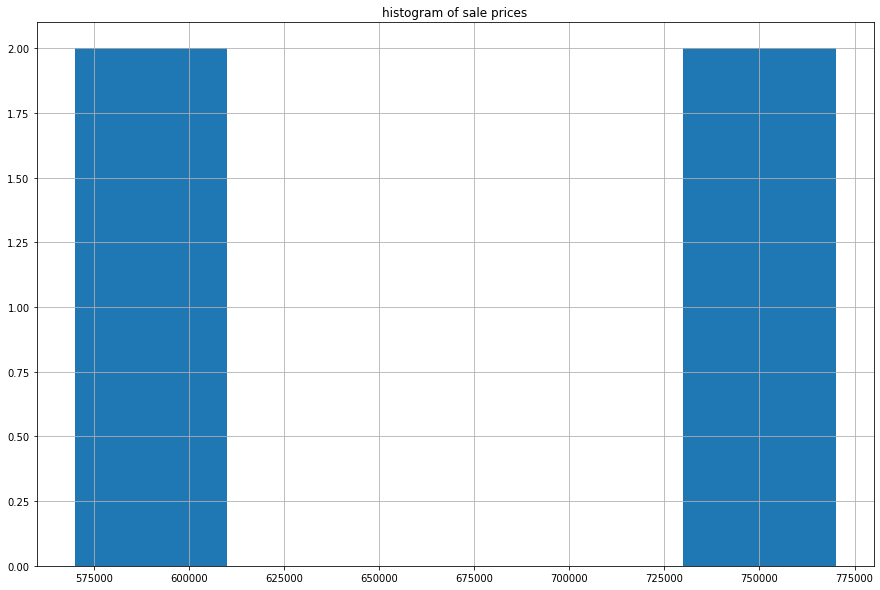

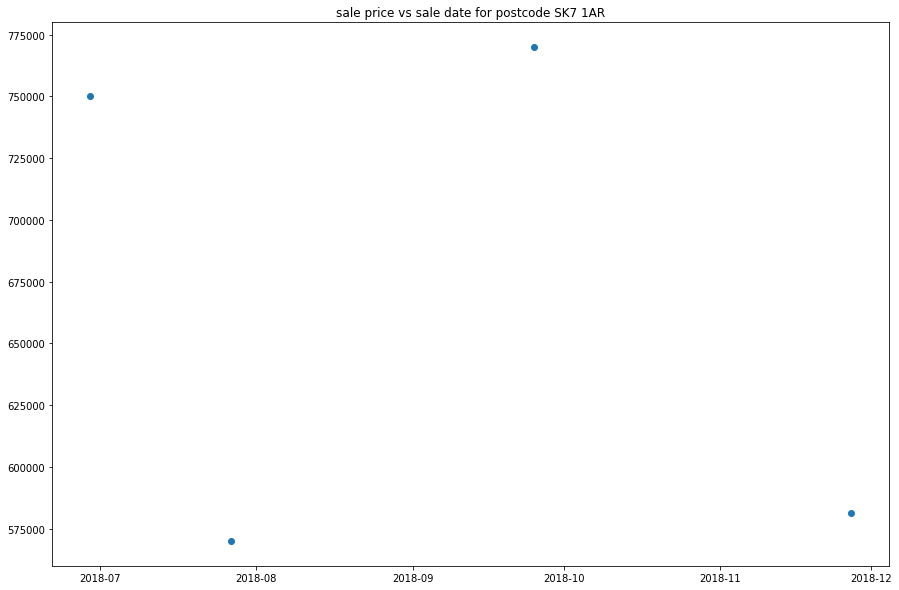

In [7]:
sales = hpe.estimate_price('SK7 1AR')

In [8]:
sales

{'most_recent_sale_price': 581500,
 'most_recent_sale_price_date': Timestamp('2018-11-27 00:00:00'),
 'mean_sale_price': 667875.0,
 'std_sale_price': 106792.92657599878,
 'std_err_sale_price': 53396.46328799939,
 'std_err_frac': 0.07994978594497382,
 'inflated_std_err_sale_price': 67237.03114319129,
 'inflated_std_err_frac': 0.0826305099447925,
 'n_sales': 4,
 'mean_sale_price_inflation_adjusted': 813707.0821433151,
 'std_sale_price_infaltion_adjusted': 134474.06228638257,
 'min_sale_price': 570000,
 'min_sale_price_date': Timestamp('2018-07-27 00:00:00'),
 'max_sale_price': 770000,
 'max_sale_price_date': Timestamp('2018-09-25 00:00:00')}

### unmatched postcode

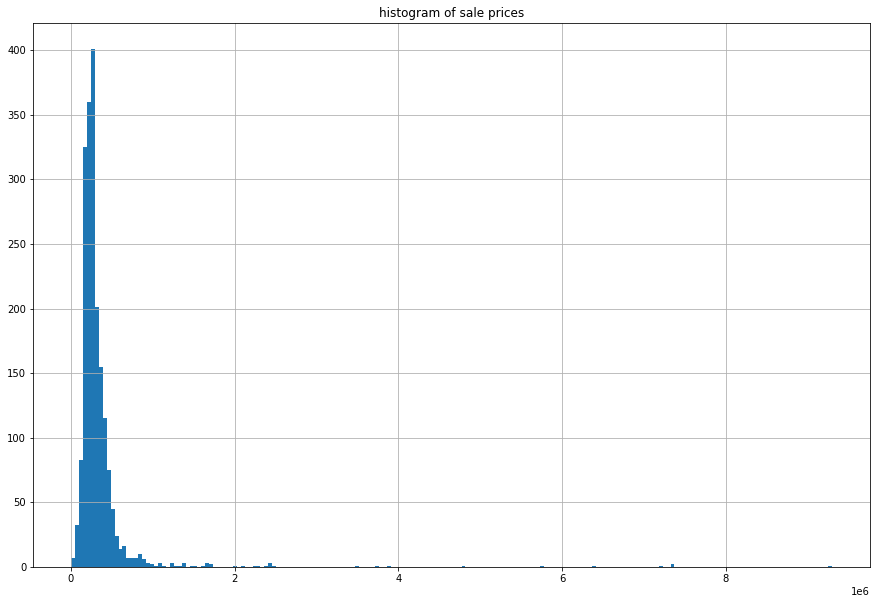

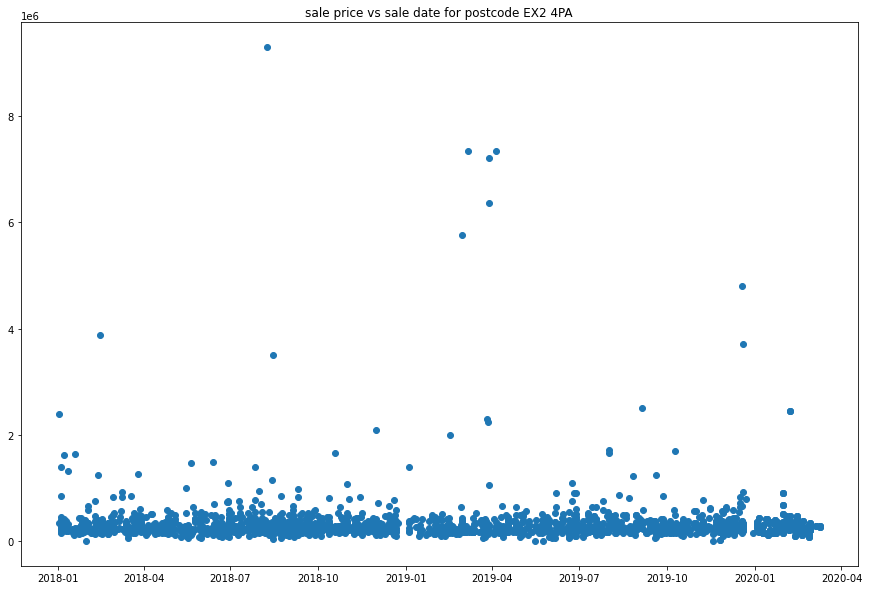

In [9]:
sales = hpe.estimate_price('EX2 9NH')

In [10]:
sales

{'most_recent_sale_price': 275000,
 'most_recent_sale_price_date': Timestamp('2020-03-09 00:00:00'),
 'mean_sale_price': 339013.25633074937,
 'std_sale_price': 479470.67826630484,
 'std_err_sale_price': 10899.876283989615,
 'std_err_frac': 0.03215177011649196,
 'inflated_std_err_sale_price': 13120.817505028748,
 'inflated_std_err_frac': 0.032098214910141185,
 'n_sales': 1935,
 'mean_sale_price_inflation_adjusted': 408770.9407442258,
 'std_sale_price_infaltion_adjusted': 577166.8507637286,
 'min_sale_price': 3500,
 'min_sale_price_date': Timestamp('2019-11-18 00:00:00'),
 'max_sale_price': 9300000,
 'max_sale_price_date': Timestamp('2018-08-08 00:00:00')}

## example with the HousePriceReccomendation wrapper

we use this subclass to set things like the fields we want returned from the base class, the uncertainty threshold

would it be better to also set a max range for our 95% confidence interval? e.g. we only say a price if our range is < £50k?



In [15]:
hpr = HousePriceReccomendation('../data', reccomendation_settings = {'uncertainty_cutoff': 0.05})

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_32046/2820493123.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  house_prices= _pp_2018.append(_pp_2019).append(_pp_2020)


### falls below our uncertainty cutoff

In [19]:
hpr.get_recommendation('SK7 1AR', plotting=False)

{'Error': 'Uncertainty in price estimate too high to be quoted'}

### does not fall below threshold

In [20]:
res = hpr.get_recommendation('EX2 9NH', plotting=False)

In [21]:
res

{'most_recent_sale_price': 275000,
 'most_recent_sale_price_date': Timestamp('2020-03-09 00:00:00'),
 'mean_sale_price': 339013.25633074937,
 'std_sale_price': 479470.67826630484,
 'std_err_frac': 0.03215177011649196,
 'n_sales': 1935,
 'mean_sale_price_inflation_adjusted': 408770.9407442258,
 'std_sale_price_infaltion_adjusted': 577166.8507637286,
 'min_sale_price': 3500,
 'max_sale_price': 9300000}

In [26]:
lower_bound = res['mean_sale_price'] - 2*res['std_sale_price']/res['n_sales']**0.5
upper_bound = res['mean_sale_price'] + 2*res['std_sale_price']/res['n_sales']**0.5

print(' we can say with 95% certainty that the house \
will be priced between \
{} and {}'.format(round(lower_bound,2), round(upper_bound,2) ))





 we can say with 95% certainty that the house will be priced between 317213.5 and 360813.01


In [25]:
lower_bound = res['mean_sale_price_inflation_adjusted'] - 2*res['std_sale_price_infaltion_adjusted']/res['n_sales']**0.5
upper_bound = res['mean_sale_price_inflation_adjusted'] + 2*res['std_sale_price_infaltion_adjusted']/res['n_sales']**0.5

print('Taking into account inflation, we can say with 95% certainty that the house \
will be priced between \
{} and {}'.format(round(lower_bound,2), round(upper_bound,2) ))


Taking into account inflation, we can say with 95% certainty that the house will be priced between 382529.31 and 435012.58
